<a href="https://colab.research.google.com/github/tansla/HWs_git/blob/master/H_W_2_cifar2_Tatiana_and_Hadas_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Implementing a Neural Network for CIFAR dataset
In this exercise, you should change H.W_1 to work on the CIFAR dataset.

CIFAR is a dataset that consists of 60,000 32x32 colour images in 10 classes (airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck), with 6000 images per class.

We will have the same components as were in the previous exercise:
- Loading the data and visualize some of the images
- Training the model. Instead of loading a pre-trained model, we will define a new very basic architecture.


## 1) Loading CIFAR dataset (10 points)

You should load the CIFAR dataset. You can use [the pytorch CIFAR tutorial](https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html). You should define a dictionary of ``dataloaders``. For now, no need to define pre-process to the data. 
Please create a dataloaders disctionary ``{'train','val'}``

You can use batch_size = 128

In [ ]:
import copy
import time
import torch
import torchvision
import torchvision.transforms as transforms
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

In [ ]:
class_names = ['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
### Enter you code here

Defining the two transformers

In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.ToTensor()
    ]),
    'val': transforms.Compose([
        transforms.ToTensor()
    ]),
}

Defining the two image sets

In [ ]:
batch_size = 128

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=data_transforms['train'])


valset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=data_transforms['val'])

dataset_sizes = {
    'train': len(trainset),
    'val': len(valset)
    }

  0%|          | 0/170498071 [00:00<?, ?it/s]

Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
len(valset)

10000

Defining the data loaders

In [ ]:
dataloaders = {
    'train': torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2),
    'val': torch.utils.data.DataLoader(valset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)
  }

In [ ]:
# Check for the availability of a GPU, and use CPU otherwise
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

**If you manage to load the CIFAR data correctly, you should run the next three cells and see some of the images.**

## Visualize some of the training images

In this dataset the size of the images are 32x32. 

It is important to visualize the data in order to see that we load them correctly (maybe we need to divide by 255? should we make channel permutations?) 

The code below was taken from H.W_1 school solution

In [ ]:
inputs, classes = next(iter(dataloaders['train']))
inputs = inputs[0:16]
classes = classes[0:16]

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    inp = np.clip(inp, 0, 1)
    fig = plt.figure(figsize=(5,3), dpi=300)
    plt.imshow(inp)
    if title is not None:
       plt.title(title, fontsize=5)
    plt.pause(0.001)  # pause a bit so that plots are updated

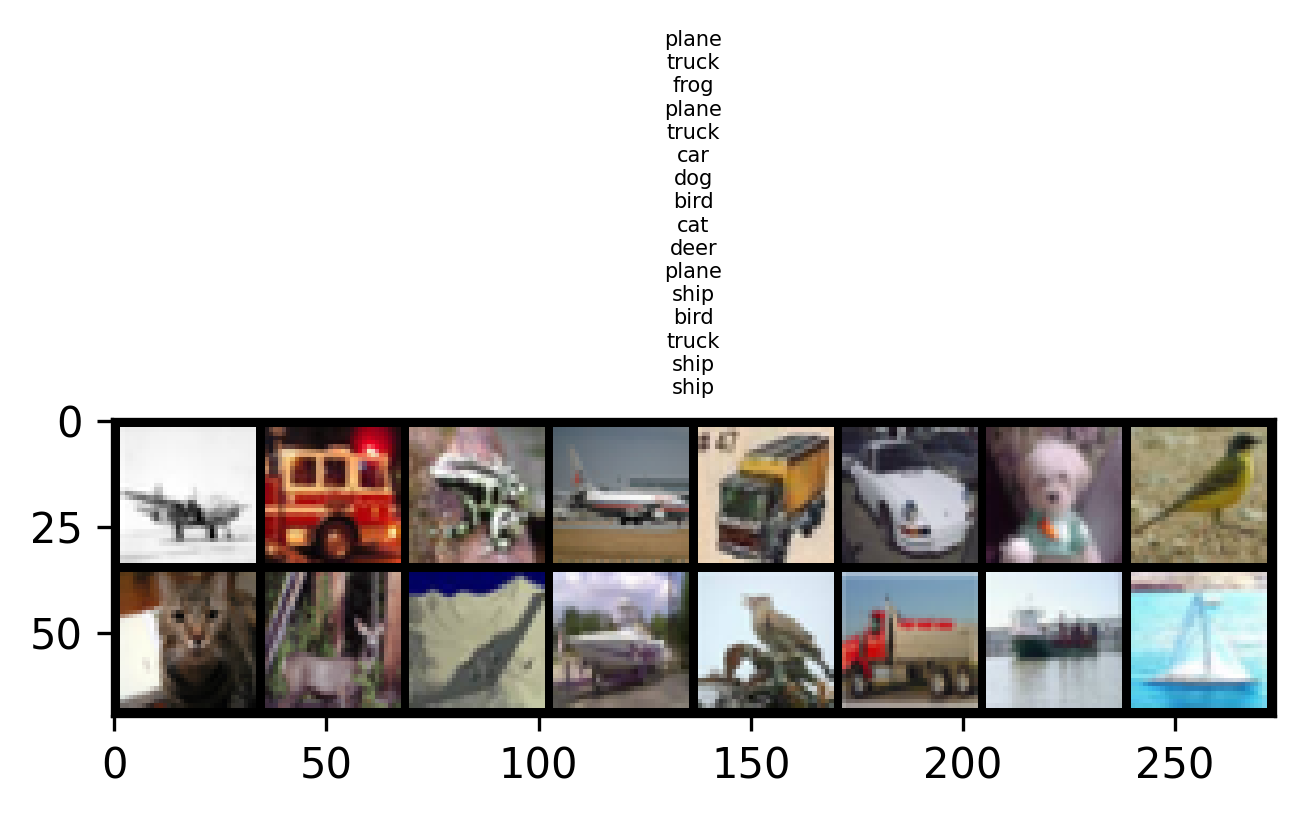

In [ ]:
# Make a grid from batch
out = torchvision.utils.make_grid(inputs, nrow=8)
imshow(out, title='\n'.join([class_names[x] for x in classes]))

## A 2-layer Neural Network

We will define 2-fully-connected-layer network using Sequential module. We have two hidden layers: the first one has 100 neurons and the second one has 20 neurons. The last layer is the output that has 10 elements.

Please pay attention that we take images after flattening (line 15 below).

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(32*32*3, 100),
            nn.ReLU(),
            nn.Linear(100, 20),
            nn.ReLU(),
            nn.Linear(20, 10),
        )


    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

In [ ]:
model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=3072, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=20, bias=True)
    (3): ReLU()
    (4): Linear(in_features=20, out_features=10, bias=True)
  )
)


**Pay attention, when you train a network and change something in the parameters, the data, data loaders, image transform, optimizations and more...you should load the model again so it will start from random weights and not from the last training**.

**You should run again the line** ``model = NeuralNetwork().to(device)``


The next two cells (defining the loss and the training loop) were copied from last exercise. 


In [ ]:
# If a GPU is available, make the model use it
model = model.to(device)

# For a multi-class problem, you'd usually prefer CrossEntropyLoss()
criterion = nn.CrossEntropyLoss()

# Use Stochastic Gradient Descent as the optimizer, with a learning rate of 0.0001 and momentum
optimizer_ft = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

num_epochs = 10

In [ ]:
def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    # Init variables that will save info about the best model
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                # Set model to training mode. 
                model.train()  
            else:
                # Set model to evaluate mode. In evaluate mode, we don't perform backprop and don't need to keep the gradients
                model.eval()   

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                # Prepare the inputs for GPU/CPU
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # ===== forward pass ======
                with torch.set_grad_enabled(phase=='train'):
                    # If we're in train mode, we'll track the gradients to allow back-propagation
                    outputs = model(inputs) # apply the model to the inputs. The output is the softmax probability of each class
                    _, preds = torch.max(outputs, 1) # 
                    loss = criterion(outputs, labels)

                    # ==== backward pass + optimizer step ====
                    # This runs only in the training phase
                    if phase == 'train':
                        loss.backward() # Perform a step in the opposite direction of the gradient
                        optimizer.step() # Adapt the optimizer

                # Collect statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            if phase == 'train':
                # Adjust the learning rate based on the scheduler
                scheduler.step()  

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Keep the results of the best model so far
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                # deepcopy the model
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {(time_elapsed // 60):.0f}m {(time_elapsed % 60):.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
model = train_model(model, 
                    dataloaders,
                       criterion, 
                       optimizer_ft, 
                       exp_lr_scheduler,
                       num_epochs=num_epochs)


Epoch 0/9
----------
train Loss: 2.2614 Acc: 0.1600
val Loss: 2.1898 Acc: 0.2139

Epoch 1/9
----------
train Loss: 2.0910 Acc: 0.2517
val Loss: 2.0062 Acc: 0.2880

Epoch 2/9
----------
train Loss: 1.9574 Acc: 0.2975
val Loss: 1.9234 Acc: 0.3098

Epoch 3/9
----------
train Loss: 1.9057 Acc: 0.3244
val Loss: 1.8898 Acc: 0.3287

Epoch 4/9
----------
train Loss: 1.8701 Acc: 0.3374
val Loss: 1.8521 Acc: 0.3472

Epoch 5/9
----------
train Loss: 1.8379 Acc: 0.3487
val Loss: 1.8212 Acc: 0.3588

Epoch 6/9
----------
train Loss: 1.8091 Acc: 0.3588
val Loss: 1.7991 Acc: 0.3629

Epoch 7/9
----------
train Loss: 1.7858 Acc: 0.3689
val Loss: 1.7863 Acc: 0.3688

Epoch 8/9
----------
train Loss: 1.7822 Acc: 0.3693
val Loss: 1.7837 Acc: 0.3700

Epoch 9/9
----------
train Loss: 1.7788 Acc: 0.3704
val Loss: 1.7807 Acc: 0.3703

Training complete in 1m 40s
Best val Acc: 0.370300


You can continue after you see your model learns something (the training loss is decreasing).

# 2) Losses in Pytorch (10 points)

Now that you managed to run the training loop, let's understand the loss definition. PyTorch provides losses such as cross-entropy loss (`nn.CrossEntropyLoss`) that has just been used. You'll usually see the loss assigned to `criterion`. For classification problems such as CIFAR, we use the softmax function to predict class probabilities. With a softmax output, we need to use cross-entropy as the loss. To actually calculate the loss, we first define the criterion, then pass in it the output of your network and the correct labels.

*Important note!* Look at [the documentation for `nn.CrossEntropyLoss`](https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html#torch.nn.CrossEntropyLoss),

> This criterion combines `nn.LogSoftmax()` and `nn.NLLLoss()` in one single class.
>
> The input is expected to contain scores for each class.

It means that we need to pass in `nn.CrossEntropyLoss` the raw output of our network into, not the output of the softmax function. This raw output is usually called the *logits* or *scores*. We use the logits because softmax gives you probabilities, which will often be very close to zero or one but floating-point numbers can't accurately represent values near zero or one ([read more here](https://docs.python.org/3/tutorial/floatingpoint.html)). It's usually better to avoid doing calculations with probabilities, and generally we use log-probabilities.

**Exercise:** Change the network above to output the log-softmax and calculate the loss using the negative log-likelihood loss. Note that for `nn.LogSoftmax` and `F.log_softmax` you'll need to set the `dim` keyword argument appropriately. `dim=0` calculates softmax across the rows, so each column sums to 1, while `dim=1` calculates across the columns so each row sums to 1. Think about what you want the output to be and choose `dim` appropriately.


**Answer**    
In the last layer of the model, the "rows" represent 10 values, for each of our classes. Therefore we will use `dim=1`, to calculate the log-softmax across the columns.

In [ ]:
class NeuralNetwork_sm(nn.Module):
    def __init__(self):
        super(NeuralNetwork_sm, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(32*32*3, 100),
            nn.ReLU(),
            nn.Linear(100, 20),
            nn.ReLU(),
            nn.Linear(20, 10),
        )
        self.logsoft = nn.LogSoftmax(dim=1)


    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        log_probs = self.logsoft(logits)
        #log_probs = nn.functional.log_softmax(logits, dim=1)
        return log_probs

Let's load the model again, and train it using the new criterion

In [ ]:
model_2 = NeuralNetwork_sm().to(device)
print(model_2)

NeuralNetwork_sm(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=3072, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=20, bias=True)
    (3): ReLU()
    (4): Linear(in_features=20, out_features=10, bias=True)
  )
  (logsoft): LogSoftmax(dim=1)
)


Updating the criterion and the optimizer (with the new model parameters)

In [ ]:
criterion_nll = nn.NLLLoss()
# Use Stochastic Gradient Descent as the optimizer, with a learning rate of 0.0001 and momentum
optimizer_ft = optim.SGD(model_2.parameters(), lr=0.001, momentum=0.9)

In [ ]:
dataset_sizes

{'train': 50000, 'val': 10000}

In [ ]:
model_2 = train_model(model_2, 
                    dataloaders,
                       criterion_nll, 
                       optimizer_ft, 
                       exp_lr_scheduler,
                       num_epochs=num_epochs)

Epoch 0/9
----------
train Loss: 2.2220 Acc: 0.1819
val Loss: 2.1146 Acc: 0.2418

Epoch 1/9
----------
train Loss: 2.0335 Acc: 0.2639
val Loss: 1.9711 Acc: 0.2993

Epoch 2/9
----------
train Loss: 1.9412 Acc: 0.3051
val Loss: 1.9145 Acc: 0.3144

Epoch 3/9
----------
train Loss: 1.8961 Acc: 0.3238
val Loss: 1.8743 Acc: 0.3372

Epoch 4/9
----------
train Loss: 1.8634 Acc: 0.3386
val Loss: 1.8472 Acc: 0.3447

Epoch 5/9
----------
train Loss: 1.8299 Acc: 0.3523
val Loss: 1.8077 Acc: 0.3618

Epoch 6/9
----------
train Loss: 1.7957 Acc: 0.3662
val Loss: 1.7740 Acc: 0.3720

Epoch 7/9
----------
train Loss: 1.7644 Acc: 0.3730
val Loss: 1.7483 Acc: 0.3777

Epoch 8/9
----------
train Loss: 1.7373 Acc: 0.3825
val Loss: 1.7168 Acc: 0.3887

Epoch 9/9
----------
train Loss: 1.7101 Acc: 0.3916
val Loss: 1.6956 Acc: 0.4007

Training complete in 1m 37s
Best val Acc: 0.400700


# 3) Debug the training (15 points)
With the default parameters we provided above, you should get a validation accuracy of about 0.2 on the validation set. This isn't very good.

One strategy for getting insight into what's wrong is to plot the loss function and the accuracies on the training and validation sets during optimization. 

**Exersice:** Write this visualization here.
(you can copy your solution from last exercies)


Adding the accuracy and loss history to the above function

In [ ]:
def train_model_and_log(model, dataloaders, criterion, optimizer, scheduler, num_epochs=25, run=0, silent=False):
    since = time.time()

    # Init variables that will save info about the best model
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    running_loss_list_train = []
    running_loss_list_test = []
    running_acc_list_train = []
    running_acc_list_test = []

    for epoch in range(num_epochs):
        if not silent:
            print('Epoch {}/{}'.format(epoch, num_epochs - 1))
            print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                # Set model to training mode. 
                model.train()  
            else:
                # Set model to evaluate mode. In evaluate mode, we don't perform backprop and don't need to keep the gradients
                model.eval()   

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                # Prepare the inputs for GPU/CPU
                inputs = inputs.to(device) # H: movet to GPU
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # ===== forward pass ======
                with torch.set_grad_enabled(phase=='train'):
                    # If we're in train mode, we'll track the gradients to allow back-propagation
                    outputs = model(inputs) # apply the model to the inputs. The output is the softmax probability of each class
                    _, preds = torch.max(outputs, 1) # 
                    loss = criterion(outputs, labels)

                    # ==== backward pass + optimizer step ====
                    # This runs only in the training phase
                    if phase == 'train':
                        loss.backward() # Perform a step in the opposite direction of the gradient
                        optimizer.step() # Adapt the optimizer

                # Collect statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            if phase == 'train':
                # Adjust the learning rate based on the scheduler
                scheduler.step()  
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase == 'train':
                running_acc_list_train.append(epoch_acc.item())
                running_loss_list_train.append(epoch_loss)
            if phase == 'val':
                running_acc_list_test.append(epoch_acc.item())
                running_loss_list_test.append(epoch_loss)
            
            if not silent:
                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Keep the results of the best model so far
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                # deepcopy the model
                best_model_wts = copy.deepcopy(model.state_dict())
        if not silent:
            print()

    time_elapsed = time.time() - since
    print(f'Training complete in {(time_elapsed // 60):.0f}m {(time_elapsed % 60):.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)

    loss_acc = {
        'running_loss_list_train': running_loss_list_train,
        'running_loss_list_test':running_loss_list_test,
        'running_acc_list_train':running_acc_list_train,
        'running_acc_list_test':running_acc_list_test
    }

    return model, loss_acc

Defining a plotting function

In [ ]:
def plot_acc_loss(loss_acc):
    fig2, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(12,4))

    #Plot the Accuracy
    ax1.plot(loss_acc['running_acc_list_train'], label='train')
    ax1.plot(loss_acc['running_acc_list_test'], label='validation')
    ax1.legend()
    ax1.set_title('Accuracy by epochs')
    ax1.set_xlabel('# epoch')
    ax1.set_ylabel('Accuracy')

    #Plot the loss
    ax2.plot(loss_acc['running_loss_list_train'], label='train')
    ax2.plot(loss_acc['running_loss_list_test'], label='validation')
    ax2.legend()
    ax2.set_title('Loss by epochs')
    ax2.set_xlabel('# epoch')
    ax2.set_ylabel('Loss')

Let's re-train the model from the start

In [ ]:
model_2 = NeuralNetwork_sm().to(device)
optimizer_ft = optim.SGD(model_2.parameters(), lr=0.001, momentum=0.9)

model, loss_acc = train_model_and_log(model_2, 
                    dataloaders,
                       criterion_nll, 
                       optimizer_ft, 
                       exp_lr_scheduler,
                       num_epochs=num_epochs)

Epoch 0/9
----------
train Loss: 2.2482 Acc: 0.1683
val Loss: 2.1579 Acc: 0.2062

Epoch 1/9
----------
train Loss: 2.0720 Acc: 0.2355
val Loss: 2.0112 Acc: 0.2665

Epoch 2/9
----------
train Loss: 1.9730 Acc: 0.2859
val Loss: 1.9389 Acc: 0.3022

Epoch 3/9
----------
train Loss: 1.9181 Acc: 0.3119
val Loss: 1.8947 Acc: 0.3226

Epoch 4/9
----------
train Loss: 1.8797 Acc: 0.3300
val Loss: 1.8591 Acc: 0.3422

Epoch 5/9
----------
train Loss: 1.8446 Acc: 0.3450
val Loss: 1.8298 Acc: 0.3551

Epoch 6/9
----------
train Loss: 1.8100 Acc: 0.3579
val Loss: 1.7965 Acc: 0.3648

Epoch 7/9
----------
train Loss: 1.7804 Acc: 0.3692
val Loss: 1.7629 Acc: 0.3755

Epoch 8/9
----------
train Loss: 1.7547 Acc: 0.3763
val Loss: 1.7376 Acc: 0.3804

Epoch 9/9
----------
train Loss: 1.7337 Acc: 0.3819
val Loss: 1.7189 Acc: 0.3880

Training complete in 1m 37s
Best val Acc: 0.388000


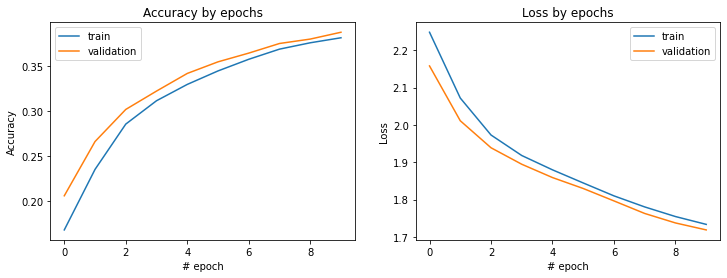

In [ ]:
plot_acc_loss(loss_acc)

# 4) Tune your hyperparameters (50 points)

**What's wrong?**. Looking at the loss above, we see that the loss is decreasing more or less linearly, which seems to suggest that the learning rate may be too low. Moreover, there is no gap between the training and validation accuracy, suggesting that the model we used has low capacity, and that we should increase its size. On the other hand, with a very large model we would expect to see more overfitting, which would manifest itself as a very large gap between the training and validation accuracy. 

**Tuning**. Tuning the hyperparameters and developing intuition for how they affect the final performance is a large part of using Neural Networks, so we want you to get a lot of practice. Below, you should experiment with different values of the various hyperparameters, including *hidden layer size, learning rate, numer of training epochs, and adding l2 or l1 regularization to the cross entropy loss*. You might also consider tuning the learning rate decay, but you should be able to get good performance using the default value.

**Approximate results**. You should be aim to achieve a classification accuracy of greater than 48% on the validation set. Our best network gets over 52% on the validation set.

**Experiment**: You goal in this exercise is to get as good of a result on CIFAR-10 as you can, with a fully-connected Neural Network. Feel free implement your own techniques (e.g. PCA to reduce dimensionality, or adding dropout, or adding features to the solver, etc.).

In [ ]:

#################################################################################
# TODO: Tune hyperparameters using the validation set.                          #
#                                                                               #
#                                                                               #
#################################################################################
# Your code
#################################################################################
#                               END OF YOUR CODE                                #
#################################################################################

## Updating the hidden layer sizes

In [ ]:
class NeuralNetwork_3(nn.Module):
    def __init__(self):
        super(NeuralNetwork_3, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(32*32*3, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 10),
        )
        self.logsoft = nn.LogSoftmax(dim=1)


    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        log_probs = self.logsoft(logits)
        #log_probs = nn.functional.log_softmax(logits, dim=1)
        return log_probs

Training complete in 1m 37s
Best val Acc: 0.413100


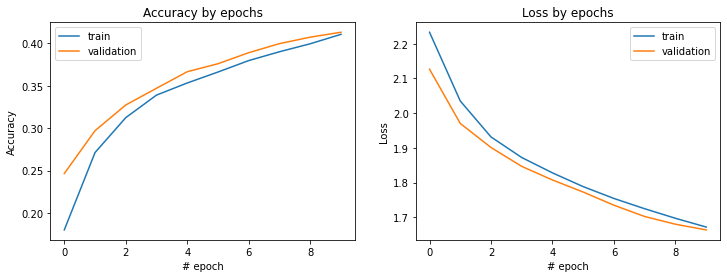

In [ ]:
model_3 = NeuralNetwork_3().to(device)
optimizer_ft = optim.SGD(model_3.parameters(), lr=0.001, momentum=0.9)

model_3, loss_acc = train_model_and_log(model_3, 
                    dataloaders,
                       criterion_nll, 
                       optimizer_ft, 
                       exp_lr_scheduler,
                       num_epochs=num_epochs, silent=True)

plot_acc_loss(loss_acc)

## Changing the learning rate

In [ ]:
def train_and_get_last_acc(Network, lr=0.001, num_epochs=10):
    curr_model = Network().to(device)
    optimizer_ft = optim.SGD(curr_model.parameters(), lr, momentum=0.9)

    curr_model, loss_acc = train_model_and_log(curr_model, 
                          dataloaders,
                          criterion_nll, 
                          optimizer_ft, 
                          exp_lr_scheduler,
                          num_epochs, silent=True)
    last_acc = loss_acc['running_acc_list_test'][-1]
    return last_acc

In [ ]:
losses = []
for lr in np.logspace(-1, -3, num=10):
    print('Learning rate:', lr)
    losses.append(train_and_get_last_acc(NeuralNetwork_3, lr=lr, num_epochs=10))
    print('-'*30)
print(losses)

Learning rate: 0.1
Training complete in 1m 37s
Best val Acc: 0.309100
------------------------------
Learning rate: 0.05994842503189409
Training complete in 1m 36s
Best val Acc: 0.439700
------------------------------
Learning rate: 0.03593813663804628
Training complete in 1m 36s
Best val Acc: 0.493000
------------------------------
Learning rate: 0.021544346900318846
Training complete in 1m 37s
Best val Acc: 0.500700
------------------------------
Learning rate: 0.01291549665014884
Training complete in 1m 37s
Best val Acc: 0.508600
------------------------------
Learning rate: 0.007742636826811269
Training complete in 1m 37s
Best val Acc: 0.517800
------------------------------
Learning rate: 0.004641588833612782
Training complete in 1m 36s
Best val Acc: 0.499300
------------------------------
Learning rate: 0.0027825594022071257
Training complete in 1m 36s
Best val Acc: 0.481600
------------------------------
Learning rate: 0.0016681005372000592
Training complete in 1m 39s
Best val A

It seems that the best learning rate is around 0.0077

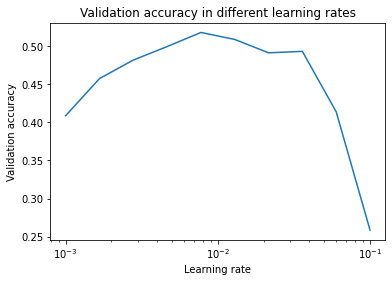

In [ ]:
plt.plot(np.logspace(-1, -3, num=10), losses)
plt.xscale("log")
plt.xlabel('Learning rate')
plt.ylabel('Validation accuracy')
plt.title('Validation accuracy in different learning rates');


## Changing the numer of training epochs

Epoch 0/49
----------
train Loss: 1.9596 Acc: 0.2934
val Loss: 1.7858 Acc: 0.3530

Epoch 1/49
----------
train Loss: 1.7225 Acc: 0.3842
val Loss: 1.6624 Acc: 0.4102

Epoch 2/49
----------
train Loss: 1.6267 Acc: 0.4214
val Loss: 1.6215 Acc: 0.4186

Epoch 3/49
----------
train Loss: 1.5550 Acc: 0.4466
val Loss: 1.5359 Acc: 0.4527

Epoch 4/49
----------
train Loss: 1.5096 Acc: 0.4633
val Loss: 1.4944 Acc: 0.4660

Epoch 5/49
----------
train Loss: 1.4684 Acc: 0.4746
val Loss: 1.5218 Acc: 0.4660

Epoch 6/49
----------
train Loss: 1.4303 Acc: 0.4915
val Loss: 1.4200 Acc: 0.4884

Epoch 7/49
----------
train Loss: 1.4015 Acc: 0.4999
val Loss: 1.4479 Acc: 0.4940

Epoch 8/49
----------
train Loss: 1.3726 Acc: 0.5107
val Loss: 1.4033 Acc: 0.5004

Epoch 9/49
----------
train Loss: 1.3491 Acc: 0.5197
val Loss: 1.4492 Acc: 0.4887

Epoch 10/49
----------
train Loss: 1.3179 Acc: 0.5311
val Loss: 1.4183 Acc: 0.5039

Epoch 11/49
----------
train Loss: 1.2987 Acc: 0.5383
val Loss: 1.4048 Acc: 0.5033

Ep

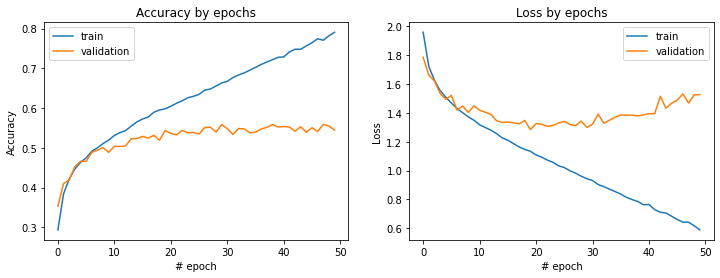

In [ ]:
# Using 50 epochs
model_3 = NeuralNetwork_3().to(device)
optimizer_ft = optim.SGD(model_3.parameters(), lr=0.0077, momentum=0.9)

model_3, loss_acc = train_model_and_log(model_3, 
                    dataloaders,
                       criterion_nll, 
                       optimizer_ft, 
                       exp_lr_scheduler,
                       num_epochs=50)

plot_acc_loss(loss_acc)

It seems that we overfit from around epoch 20.

## Adding l2 or l1 regularization to the cross entropy loss

Epoch 0/9
----------
train Loss: 1.9605 Acc: 0.2894
val Loss: 1.7947 Acc: 0.3611

Epoch 1/9
----------
train Loss: 1.7317 Acc: 0.3801
val Loss: 1.6671 Acc: 0.4066

Epoch 2/9
----------
train Loss: 1.6296 Acc: 0.4213
val Loss: 1.6027 Acc: 0.4232

Epoch 3/9
----------
train Loss: 1.5606 Acc: 0.4430
val Loss: 1.5180 Acc: 0.4597

Epoch 4/9
----------
train Loss: 1.5133 Acc: 0.4600
val Loss: 1.5243 Acc: 0.4600

Epoch 5/9
----------
train Loss: 1.4687 Acc: 0.4770
val Loss: 1.4875 Acc: 0.4607

Epoch 6/9
----------
train Loss: 1.4339 Acc: 0.4880
val Loss: 1.4826 Acc: 0.4756

Epoch 7/9
----------
train Loss: 1.4034 Acc: 0.4987
val Loss: 1.4188 Acc: 0.5021

Epoch 8/9
----------
train Loss: 1.3756 Acc: 0.5116
val Loss: 1.4163 Acc: 0.4918

Epoch 9/9
----------
train Loss: 1.3446 Acc: 0.5201
val Loss: 1.4092 Acc: 0.4965

Training complete in 1m 36s
Best val Acc: 0.502100


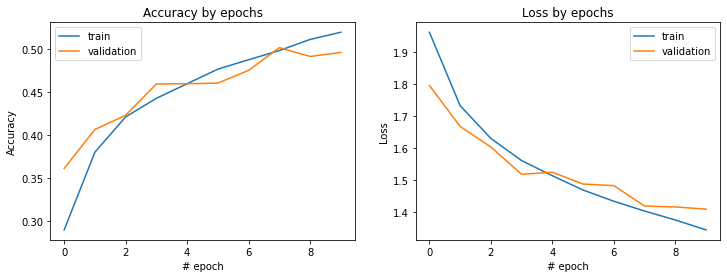

In [ ]:
# Using L2 regularization
model_5 = NeuralNetwork_3().to(device)
optimizer_ft = torch.optim.SGD(model_5.parameters(), lr=0.0077, momentum=0.9, weight_decay=1e-5)

model_5, loss_acc = train_model_and_log(model_5, 
                    dataloaders,
                       criterion, 
                       optimizer_ft, 
                       exp_lr_scheduler,
                       num_epochs=10)

plot_acc_loss(loss_acc)

In [ ]:
def train_model_and_log_l1(model, dataloaders, criterion, optimizer, scheduler, num_epochs=25, run=0, silent=False, l1_lambda=None):
    since = time.time()

    # Init variables that will save info about the best model
    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    running_loss_list_train = []
    running_loss_list_test = []
    running_acc_list_train = []
    running_acc_list_test = []

    for epoch in range(num_epochs):
        if not silent:
            print('Epoch {}/{}'.format(epoch, num_epochs - 1))
            print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                # Set model to training mode. 
                model.train()  
            else:
                # Set model to evaluate mode. In evaluate mode, we don't perform backprop and don't need to keep the gradients
                model.eval()   

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data
            for inputs, labels in dataloaders[phase]:
                # Prepare the inputs for GPU/CPU
                inputs = inputs.to(device) # H: movet to GPU
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # ===== forward pass ======
                with torch.set_grad_enabled(phase=='train'):
                    # If we're in train mode, we'll track the gradients to allow back-propagation
                    outputs = model(inputs) # apply the model to the inputs. The output is the softmax probability of each class
                    _, preds = torch.max(outputs, 1) # 
                    loss = criterion(outputs, labels)

                    # ==== L1 regularization ====
                    if l1_lambda is not None:
                        l1_reg = torch.tensor(0., device=device)
                        for name, param in model.named_parameters():
                            if 'weight' in name:
                                l1_reg += torch.norm(param, 1)
                        loss += l1_lambda * l1_reg

                    # ==== backward pass + optimizer step ====
                    # This runs only in the training phase
                    if phase == 'train':
                        loss.backward() # Perform a step in the opposite direction of the gradient
                        optimizer.step() # Adapt the optimizer

                # Collect statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
                
            if phase == 'train':
                # Adjust the learning rate based on the scheduler
                scheduler.step()  
            
            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            if phase == 'train':
                running_acc_list_train.append(epoch_acc.item())
                running_loss_list_train.append(epoch_loss)
            if phase == 'val':
                running_acc_list_test.append(epoch_acc.item())
                running_loss_list_test.append(epoch_loss)
            
            if not silent:
                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # Keep the results of the best model so far
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                # deepcopy the model
                best_model_wts = copy.deepcopy(model.state_dict())
        if not silent:
            print()

    time_elapsed = time.time() - since
    print(f'Training complete in {(time_elapsed // 60):.0f}m {(time_elapsed % 60):.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)

    loss_acc = {
        'running_loss_list_train': running_loss_list_train,
        'running_loss_list_test':running_loss_list_test,
        'running_acc_list_train':running_acc_list_train,
        'running_acc_list_test':running_acc_list_test
    }

    return model, loss_acc

Epoch 0/9
----------
train Loss: 3.4721 Acc: 0.2893
val Loss: 3.0906 Acc: 0.3571

Epoch 1/9
----------
train Loss: 2.8602 Acc: 0.3679
val Loss: 2.6034 Acc: 0.4086

Epoch 2/9
----------
train Loss: 2.4829 Acc: 0.3980
val Loss: 2.3073 Acc: 0.4154

Epoch 3/9
----------
train Loss: 2.2217 Acc: 0.4124
val Loss: 2.1468 Acc: 0.4012

Epoch 4/9
----------
train Loss: 2.0553 Acc: 0.4234
val Loss: 1.9981 Acc: 0.4251

Epoch 5/9
----------
train Loss: 1.9533 Acc: 0.4262
val Loss: 1.9283 Acc: 0.4280

Epoch 6/9
----------
train Loss: 1.8846 Acc: 0.4355
val Loss: 1.8873 Acc: 0.4220

Epoch 7/9
----------
train Loss: 1.8333 Acc: 0.4426
val Loss: 1.8190 Acc: 0.4458

Epoch 8/9
----------
train Loss: 1.7810 Acc: 0.4520
val Loss: 1.7369 Acc: 0.4658

Epoch 9/9
----------
train Loss: 1.7531 Acc: 0.4546
val Loss: 1.8016 Acc: 0.4411

Training complete in 1m 39s
Best val Acc: 0.465800


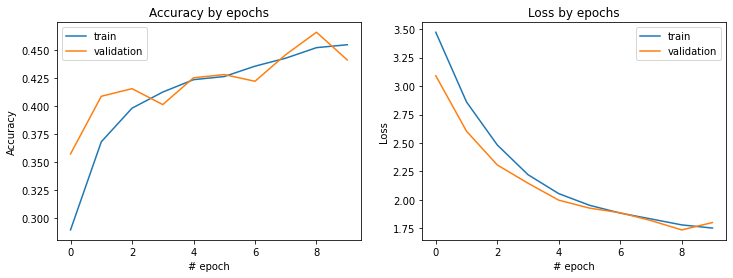

In [ ]:
# Using L1 regularization
model_6 = NeuralNetwork_3().to(device)
optimizer_ft = torch.optim.SGD(model_6.parameters(), lr=0.0077, momentum=0.9)

model_6, loss_acc = train_model_and_log_l1(model_6, 
                    dataloaders,
                       criterion, 
                       optimizer_ft, 
                       exp_lr_scheduler,
                       num_epochs=10,
                       l1_lambda=0.0001
                       )

plot_acc_loss(loss_acc)

In [ ]:
class NeuralNetwork_4(nn.Module):
    def __init__(self):
        super(NeuralNetwork_4, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(32*32*3, 512),
            nn.ReLU(),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 10),
        )
        self.logsoft = nn.LogSoftmax(dim=1)


    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        log_probs = self.logsoft(logits)
        #log_probs = nn.functional.log_softmax(logits, dim=1)
        return log_probs

Epoch 0/14
----------
train Loss: 2.0539 Acc: 0.2357
val Loss: 1.8781 Acc: 0.3215

Epoch 1/14
----------
train Loss: 1.7957 Acc: 0.3518
val Loss: 1.6884 Acc: 0.3924

Epoch 2/14
----------
train Loss: 1.6844 Acc: 0.3929
val Loss: 1.6293 Acc: 0.4111

Epoch 3/14
----------
train Loss: 1.6076 Acc: 0.4240
val Loss: 1.5959 Acc: 0.4195

Epoch 4/14
----------
train Loss: 1.5522 Acc: 0.4438
val Loss: 1.5206 Acc: 0.4535

Epoch 5/14
----------
train Loss: 1.5013 Acc: 0.4619
val Loss: 1.4736 Acc: 0.4743

Epoch 6/14
----------
train Loss: 1.4599 Acc: 0.4766
val Loss: 1.4725 Acc: 0.4763

Epoch 7/14
----------
train Loss: 1.4348 Acc: 0.4879
val Loss: 1.4512 Acc: 0.4755

Epoch 8/14
----------
train Loss: 1.3940 Acc: 0.5001
val Loss: 1.4209 Acc: 0.4952

Epoch 9/14
----------
train Loss: 1.3662 Acc: 0.5099
val Loss: 1.4082 Acc: 0.5013

Epoch 10/14
----------
train Loss: 1.3372 Acc: 0.5215
val Loss: 1.4048 Acc: 0.4928

Epoch 11/14
----------
train Loss: 1.3058 Acc: 0.5335
val Loss: 1.3885 Acc: 0.4981

Ep

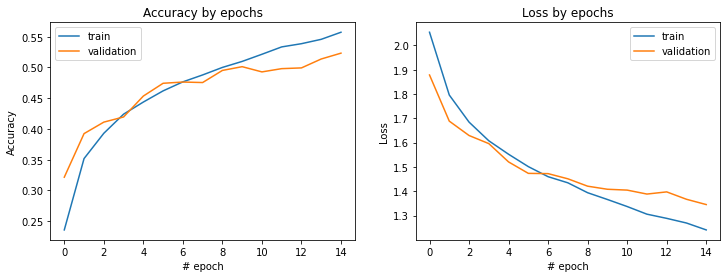

In [ ]:
model_7 = NeuralNetwork_4().to(device)
optimizer_ft = torch.optim.SGD(model_7.parameters(), lr=0.0077, momentum=0.9)

model_7, loss_acc = train_model_and_log(model_7, 
                    dataloaders,
                       criterion, 
                       optimizer_ft, 
                       exp_lr_scheduler,
                       num_epochs=15
                       )

plot_acc_loss(loss_acc)

In [ ]:
class NeuralNetwork_5(nn.Module):
    def __init__(self, p=0.3):
        super(NeuralNetwork_5, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(32*32*3, 512),
            nn.ReLU(),
            nn.Dropout(p=p),  # Add dropout layer with probability p
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Dropout(p=p),  # Add dropout layer with probability p
            nn.Linear(256, 10),
        )
        self.logsoft = nn.LogSoftmax(dim=1)


    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        log_probs = self.logsoft(logits)
        #log_probs = nn.functional.log_softmax(logits, dim=1)
        return log_probs

Epoch 0/14
----------
train Loss: 2.0091 Acc: 0.2638
val Loss: 1.8276 Acc: 0.3408

Epoch 1/14
----------
train Loss: 1.8107 Acc: 0.3482
val Loss: 1.7046 Acc: 0.3907

Epoch 2/14
----------
train Loss: 1.7294 Acc: 0.3797
val Loss: 1.6473 Acc: 0.4094

Epoch 3/14
----------
train Loss: 1.6809 Acc: 0.4002
val Loss: 1.5932 Acc: 0.4322

Epoch 4/14
----------
train Loss: 1.6431 Acc: 0.4127
val Loss: 1.5667 Acc: 0.4467

Epoch 5/14
----------
train Loss: 1.6162 Acc: 0.4241
val Loss: 1.5341 Acc: 0.4583

Epoch 6/14
----------
train Loss: 1.5857 Acc: 0.4330
val Loss: 1.4957 Acc: 0.4736

Epoch 7/14
----------
train Loss: 1.5632 Acc: 0.4418
val Loss: 1.4960 Acc: 0.4704

Epoch 8/14
----------
train Loss: 1.5448 Acc: 0.4487
val Loss: 1.4774 Acc: 0.4680

Epoch 9/14
----------
train Loss: 1.5223 Acc: 0.4571
val Loss: 1.4696 Acc: 0.4773

Epoch 10/14
----------
train Loss: 1.5067 Acc: 0.4609
val Loss: 1.4628 Acc: 0.4715

Epoch 11/14
----------
train Loss: 1.5001 Acc: 0.4662
val Loss: 1.4428 Acc: 0.4877

Ep

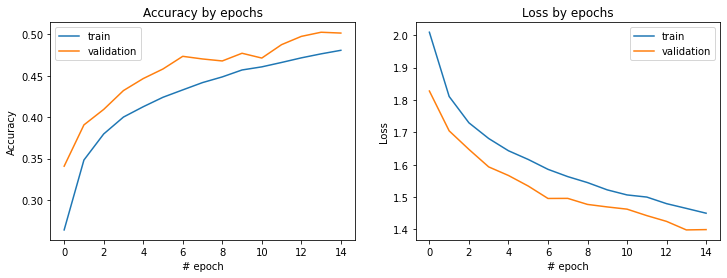

In [ ]:
model_8 = NeuralNetwork_5().to(device)
optimizer_ft = torch.optim.SGD(model_8.parameters(), lr=0.0077, momentum=0.9)

model_8, loss_acc = train_model_and_log(model_8, 
                    dataloaders,
                       criterion, 
                       optimizer_ft, 
                       exp_lr_scheduler,
                       num_epochs=15
                       )

plot_acc_loss(loss_acc)

Epoch 0/16
----------
train Loss: 1.9584 Acc: 0.2883
val Loss: 1.7752 Acc: 0.3625

Epoch 1/16
----------
train Loss: 1.7265 Acc: 0.3805
val Loss: 1.6566 Acc: 0.4097

Epoch 2/16
----------
train Loss: 1.6258 Acc: 0.4217
val Loss: 1.5608 Acc: 0.4400

Epoch 3/16
----------
train Loss: 1.5621 Acc: 0.4464
val Loss: 1.5632 Acc: 0.4447

Epoch 4/16
----------
train Loss: 1.5102 Acc: 0.4643
val Loss: 1.5347 Acc: 0.4497

Epoch 5/16
----------
train Loss: 1.4612 Acc: 0.4788
val Loss: 1.4736 Acc: 0.4795

Epoch 6/16
----------
train Loss: 1.4327 Acc: 0.4903
val Loss: 1.4514 Acc: 0.4869

Epoch 7/16
----------
train Loss: 1.4010 Acc: 0.5012
val Loss: 1.4290 Acc: 0.4915

Epoch 8/16
----------
train Loss: 1.3718 Acc: 0.5107
val Loss: 1.3914 Acc: 0.5056

Epoch 9/16
----------
train Loss: 1.3341 Acc: 0.5235
val Loss: 1.4222 Acc: 0.4960

Epoch 10/16
----------
train Loss: 1.3198 Acc: 0.5288
val Loss: 1.4179 Acc: 0.4928

Epoch 11/16
----------
train Loss: 1.3009 Acc: 0.5355
val Loss: 1.3883 Acc: 0.5075

Ep

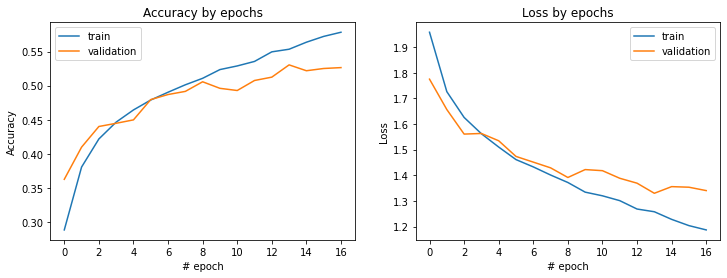

In [ ]:
model_9 = NeuralNetwork_3().to(device)
optimizer_ft = optim.SGD(model_9.parameters(), lr=0.0077, momentum=0.9)

model_9, loss_acc = train_model_and_log(model_9, 
                    dataloaders,
                       criterion_nll, 
                       optimizer_ft, 
                       exp_lr_scheduler,
                       num_epochs=17)

plot_acc_loss(loss_acc)

# Interview Question (15 points)

Now that you have trained a Neural Network classifier, you may find that your testing accuracy is lower than the training accuracy. In what ways can we decrease this gap? Select all that apply.
1. Train on a larger dataset.
2. Add more hidden units.
3. Increase the regularization strength.
4. None of the above.

*Your answer*:


*Your explanation:*



We saw that L1 regularization helped to decrease this gap in the examples above, but it tends to overfitt on the train data, so we have to be carefull with the values of the parametrs. We could think that it because with this regularisation we trying to avoid some features to be more strong that might just hold the data from train data.

Also hidden layes with the same amount of data most probably will lead to more higher accuracy on a train data while the NN will learn ot better with more place to save knoledge. But if we will add more data and use some drop out all this together could help if our model will became more generalise and less specific for the train data.


Using larger dataset could help us decrease the gap in terms of increasing the loss in a train dataset - because the NN wouldn't be able to "remember" data.